# Calibration with GLUAttention

In [28]:
import numpy as np
# import pandas as pd

import torch 

import sys
sys.path.append('../')
sys.path.append('../../')

# 导入模型
from Networks.nn import NN_pricing_GLUAttention
from Pricing.rBergomi.rBergomi_utils import *
from calibrate_utils import *

# 评估使用 cpu
device = torch.device('cpu')

hyperparams = { 
    "input_dim": 4,
    'embed_dim': 32,
    'num_heads': 2, 
    'hidden_dim': 64, 
    'hidden_nums': 4, 
    'output_dim': 88
}

model = NN_pricing_GLUAttention(hyperparams=hyperparams).to(device=device, dtype=torch.float64)


model_state = torch.load( 
    r'../../Results/models/GLUAttention_rBergomi_flat_forward_variance.pth'
)
model.load_state_dict(model_state)

# 设置为 eval mode
model.eval()
model.to(device=device, dtype=torch.float64)

NN_pricing_GLUAttention(
  (param_embed): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (glu_attn): GLUAttention(
    (qkv_proj): Linear(in_features=32, out_features=96, bias=True)
    (out_proj): Linear(in_features=32, out_features=32, bias=True)
    (glu): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): SiLU()
    )
  )
  (context_proj): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (output_mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=88, bias=True)
  )
)

In [29]:
xx, yy, strikes, maturities = data_read(r"../../Data/rBergomiTrainSet.txt.gz")

# 训练集的 Upper and Lower Bounds
upper_bound = np.array([0.16,4,-0.1,0.5])
lower_bound = np.array([0.01,0.3,-0.95,0.025])

网格数据形状：(40000, 92)
参数形状：(40000, 4)
隐含波动率曲面形状：(40000, 88)
参数上界: [ 0.16      4.       -0.100011  0.499998]
参数下界: [ 0.0100133  0.300028  -0.949934   0.0250066]


In [30]:
x_train_transform, y_train_transform, x_test_transform, y_test_transform = get_transform_train_test_data(xx, yy, upper_bound, lower_bound, 0.15)

## `SciPy` 校准

In [31]:
def CostFunc(x,sample_ind):
    return np.sum( 
        np.power((model(torch.tensor(np.array([x]), dtype=torch.float64)).detach().numpy() - y_test_transform[sample_ind]),2)
    )

Approx_scipy, Timing_scipy = calibrate_with_scipy(CostFunc, x_test_transform, upper_bound, lower_bound)

SciPy 优化结果 (前 3 轮):
 [[[ 0.10410884  0.55830423 -0.74952683  0.22823095]
  [ 0.10410885  0.55830442 -0.7495268   0.22823089]
  [ 0.10410885  0.55830441 -0.74952681  0.22823087]]

 [[ 0.15239595  3.36446937 -0.45520507  0.29518622]
  [ 0.15239598  3.36447026 -0.45520501  0.29518619]
  [ 0.15239595  3.36446942 -0.45520509  0.29518621]]

 [[ 0.09170095  1.99668658 -0.6321326   0.13800575]
  [ 0.09170092  1.99668541 -0.63213277  0.13800568]
  [ 0.09170095  1.99668656 -0.63213261  0.13800573]]]
SciPy 优化时间 (前 3 轮):
 [array([0.12756014, 0.05722713, 0.21317077]), array([0.05393338, 0.04751539, 0.1770196 ]), array([0.07375431, 0.05980253, 0.29025984])]


In [32]:
methods=["L-BFGS-B ","SLSQP","BFGS"]

for i in range(3):
    Approx_scipy_lst=[Approx_scipy[j][i] for j in range(len(Approx_scipy))]
    Timing_scipy_lst=[Timing_scipy[j][i] for j in range(len(Timing_scipy))]

    np.savetxt(f"../../Results/Calibration/rBergomi_GLUAttention_calibrate_scipy_quasi_newton_{methods[i]}.txt", Approx_scipy_lst)
    np.savetxt(f"../../Results/Calibration/rBergomi_GLUAttention_calibrate_scipy_quasi_newton_{methods[i]}_time.txt", Timing_scipy_lst)

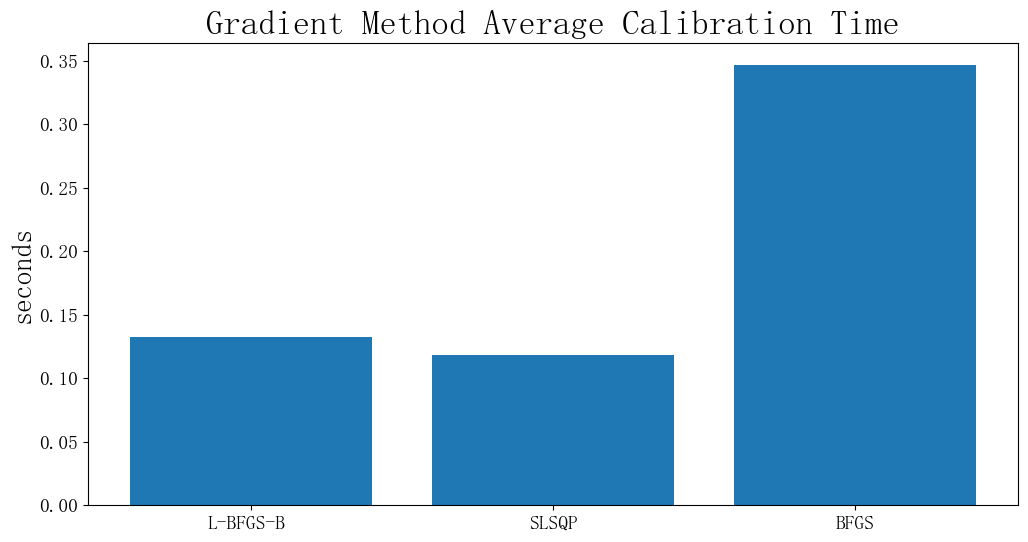

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

methods=["L-BFGS-B ","SLSQP","BFGS"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing_scipy,axis=0))
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("seconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

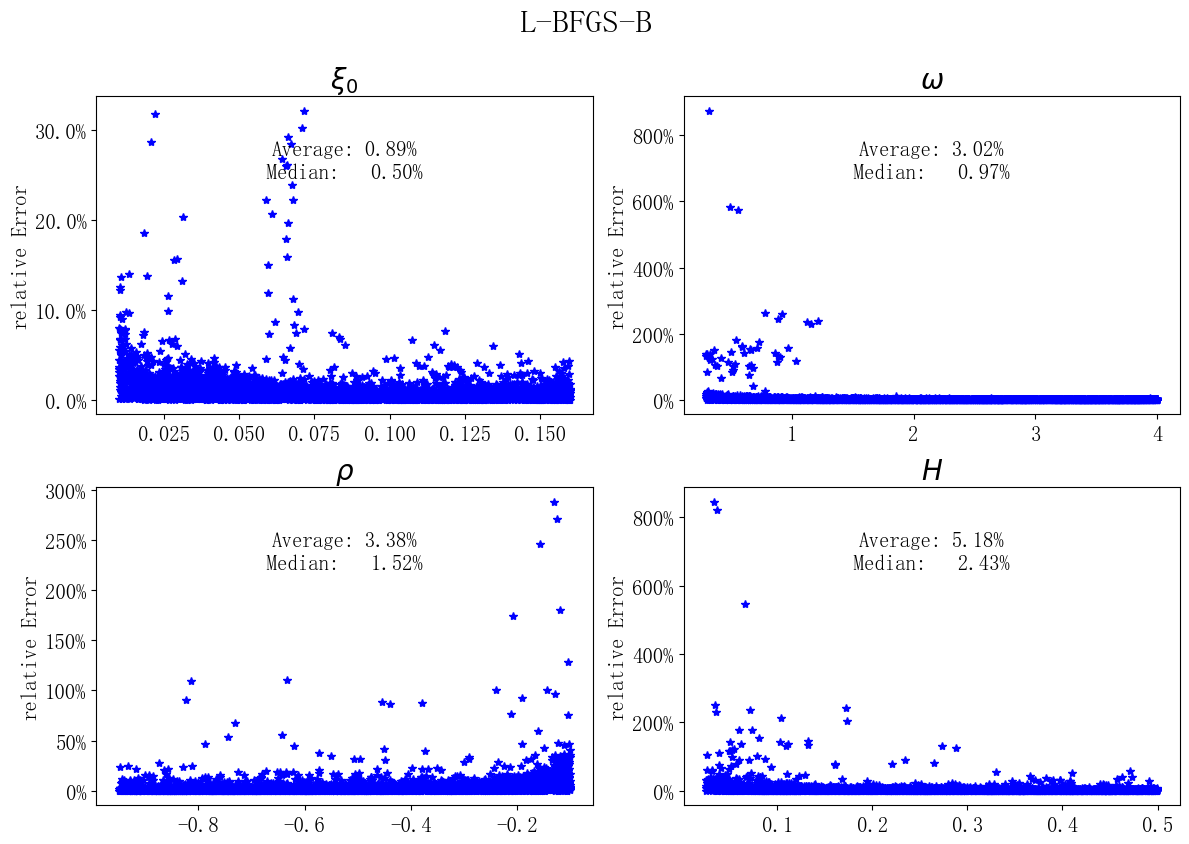

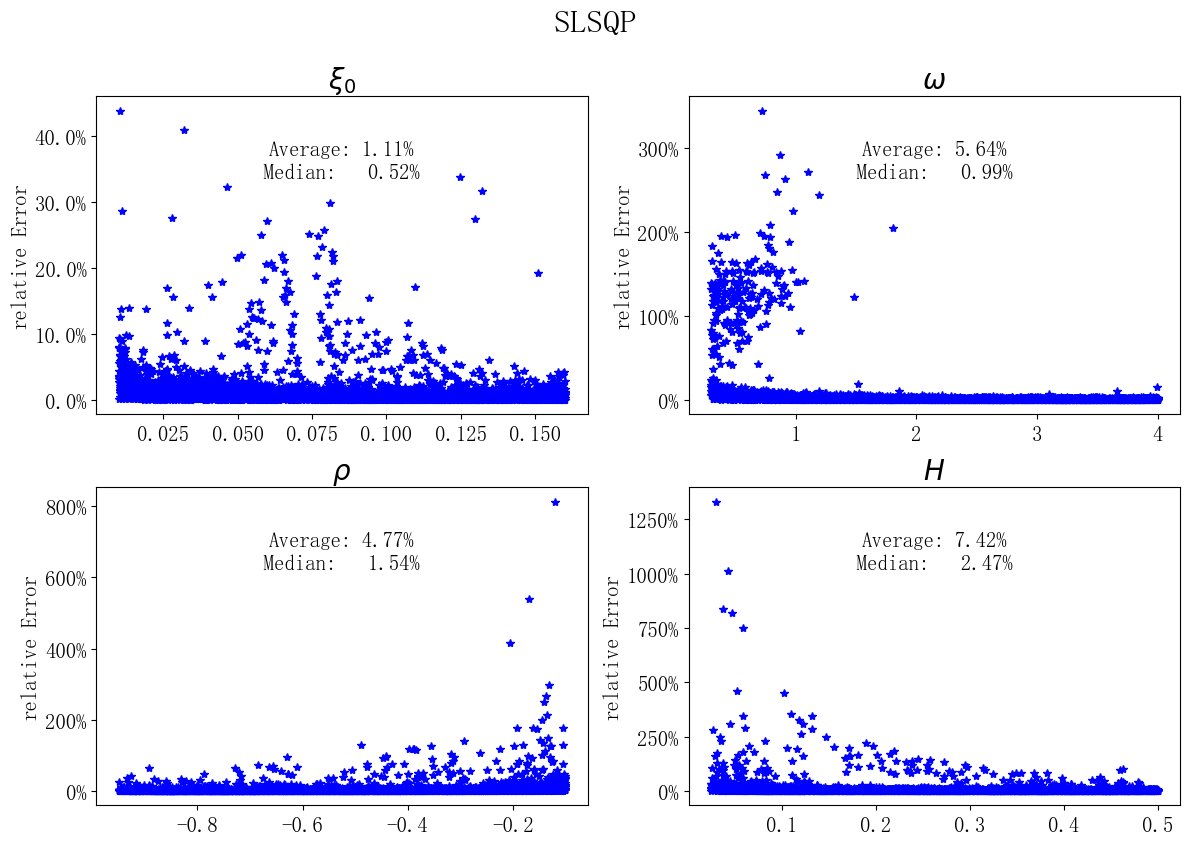

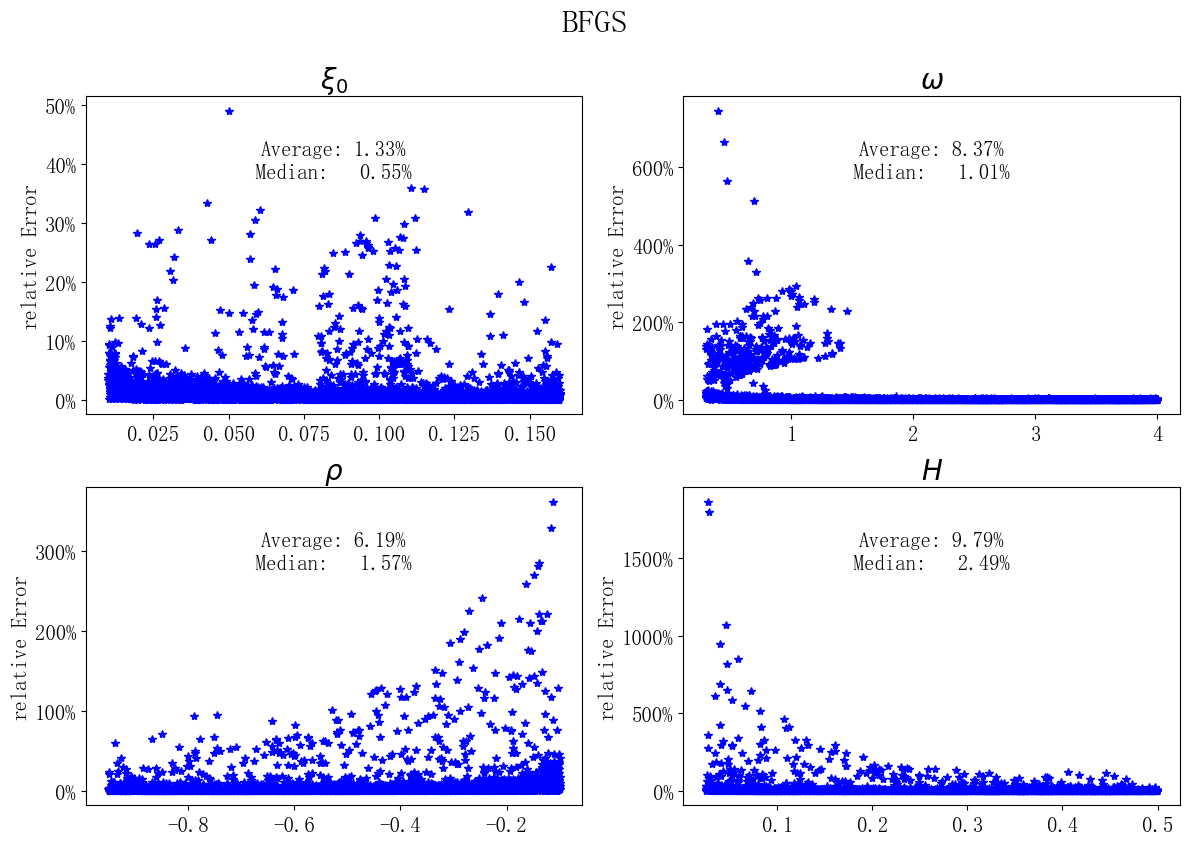

In [34]:
x_test = params_inv_scaler(x_test_transform, upper_bound, lower_bound)

for mtd in range(3):
    LMParameters = [Approx_scipy[i][mtd] for i in range(len(Approx_scipy))]
    LMParameters = np.array(LMParameters)

    titles=["$\\xi_0$","$\\omega$","$\\rho$","$H$"]
    average=np.zeros([4,6000])
    fig=plt.figure(figsize=(12,8))
    for u in range(4):
        ax=plt.subplot(2,2,u+1)
        x=x_test[:6000,u]
        plt.plot(x,100*np.abs(LMParameters[:6000,u]-x)/np.abs(x),'b*')
        average[u,:]=np.abs(LMParameters[:6000,u]-x)/np.abs(x)
        
        plt.title(titles[u],fontsize=20)
        plt.ylabel('relative Error',fontsize=15)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.tick_params(axis='both', which='minor', labelsize=15)
        plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
    plt.tight_layout()
    plt.suptitle(f"{methods[mtd]}", fontsize=24, y=1.05)
    plt.show()